# Import packages

In [3]:
import nidaqmx
from nidaqmx import Task
from nidaqmx import system
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import curve_fit
#import serial
#import time
import os 

# Define functions

In [5]:
# set potential profile and acquire data 
def pot_step_and_measure():
    
    ''' 
    This function writes a potential profile into the ao0 output of the potentiostat to set the potential 
    between the WE and RE. At the same time, potential acquisitions are being made by the channel ai0 and ai1
    inputs. ai0 measures the WE potential while ai1 measures the potential across the measurement resistor Rm
    which measures the potential between the WE and RE and ai0 at the measurement resistor
    
    The potential profile and sampling rate should be defined prior to running this function. 

    Outputs: 
        acquired_data = nested array containing potentials measured at the WE and Rm. 
    
    '''    
    
    
    '''Get device name '''
    
    # get a list of all devices connected
    all_devices = list(nidaqmx.system.System.local().devices)
    # get name of first device
    dev_name = all_devices[0].name
    #print(dev_name)


    ''' set potential profile and acquire data'''
    
    with Task() as task_o, Task() as task_i, Task():
        
        # add ai0 and ai1 input channel to read WE and Rm potential
        task_i.ai_channels.add_ai_voltage_chan(dev_name + "/ai0:1", min_val=-10.0, max_val=10.0)
        # add ai0 output ao0 channel for setting the potential profile
        task_o.ao_channels.add_ao_voltage_chan(dev_name + "/ao0", min_val=-10.0, max_val=10.0)
        
        # Set sampling rates for input and output channels
        task_i.timing.cfg_samp_clk_timing(rate = samp_rate, samps_per_chan=samp_num_tot) 
        task_o.timing.cfg_samp_clk_timing(rate = samp_rate, samps_per_chan=samp_num_tot) 

        # set up a digital trigger for the output channel to set the potential
        task_o.triggers.start_trigger.cfg_dig_edge_start_trig('/'+ dev_name +'/ai/StartTrigger')
        # define output channel task. Task will only execute when the output channel trigger is activated
        task_o.write(pot_profile, auto_start = False)
        task_o.start()                                                                                                                     
                                                              
        #time.sleep(5)w
        
        # Acquire data from input channels. This will trigger the potential profile to be set by the output channel
        acquired_data = task_i.read(number_of_samples_per_channel=samp_num_tot, timeout=nidaqmx.constants.WAIT_INFINITELY)

    return acquired_data

In [6]:
def fit_func(t, D):
    
    ''' 
    Derived equation from prelab. This describes the time dependence of current after a potential step
    
    inputs:
        dC = change in concentration as a result of the potential step
        dT = change in time
        D = diffusion coefficient in cm^2/s
        
    returns: 
        i = current as a function of time
    '''

    n = 1
    F = 96500 # Faraday's constant (C/mol)
    A = np.pi*(2.54/4)**2 # electrode diameter = 1/2 inch 
    dC = 5e-7 # concentration change (mol/cm^3)
    
    return 1*(n*F*A*np.sqrt(D)*dC)/(np.sqrt(4*t))

# Potential Step

## Setting up potential profile

Code block 1 constructs the potential profile driven to the working electrode relative to the reference electrode. The potential profile consists of 3 sections: 

 1) a potential hold at some staring potential (usually OCV) <br>
 2) a potential step then hold at some higher potential <br>
 3) a potential rest which returns the potential back to some rest potential 

The total time for each section is determined by the number of samples sent to the output channel and the sampling rate.  

In [4]:
np.repeat?

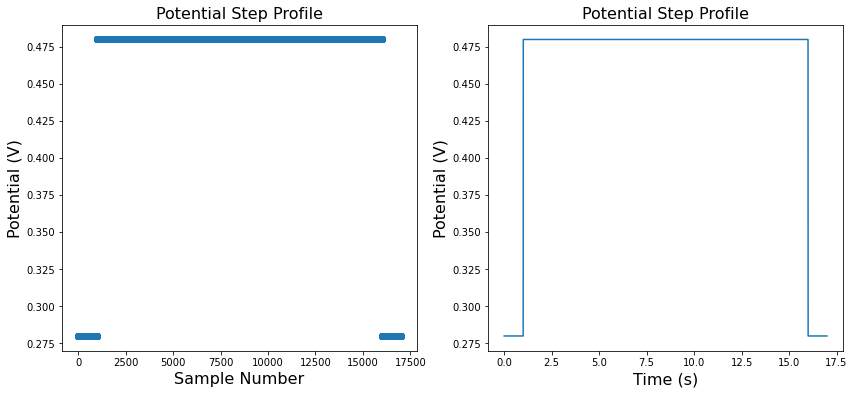

In [8]:
'''Code block 1'''


'''Set up potential profile'''

# potential to be set for each section
pot_init = 0.2798
pot_step = 0.4798
pot_rest = 0.2798

# number of potential samples to be set in each section
samp_num_init = 1000
samp_num_step = 15000
samp_num_rest = 1000

# potential profile for each section 
pot_profile_init = pot_init*np.repeat(1, samp_num_init)
pot_profile_step = pot_step*np.repeat(1, samp_num_step)
pot_profile_rest = pot_rest*np.repeat(1, samp_num_rest)

# combine potential profiles for each section. This is the total potential profile to be set by the potentiostat
pot_profile = np.concatenate((pot_profile_init, pot_profile_step, pot_profile_rest))

# sampling rate 
samp_rate = 1000


''' Calculate potential profile timing '''
    
# total number of samples to be set in the potential profile
samp_num_tot = np.sum([samp_num_init, samp_num_step, samp_num_rest])
# Calculate timing of the potential profile. Samples are set by some time interval depending on the sampling rate.
total_step_time = np.arange(0, len(pot_profile), 1)/samp_rate


''' set up subplot '''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

# subplot 1: potential profile vs samples
ax1.set_title('Potential Step Profile', fontsize = 16)
ax1.scatter(np.arange(0, len(pot_profile), 1), pot_profile)
ax1.set_xlabel('Sample Number', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)

# subplot 2: potential profile vs time 
ax2.set_title('Potential Step Profile', fontsize = 16)
ax2.plot(total_step_time, pot_profile)
ax2.set_xlabel('Time (s)', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)
#plt.title('Potential Step Profile', fontsize = 16)

plt.show()

# Set potential and acquire data

Code block 2 sets the potential profile specified in code block 1 and then simultanously acquires data. The profile and sampling rates must be defined prior to running this. 

We also calculate the current passing measurement resistor Rm when the potential profile is set.

In [10]:
'''Code block 2'''

# set potential and acquire data
acquired_data = pot_step_and_measure()
WE_step_data = np.array(acquired_data[0]) 
Rm_step_data = np.array(acquired_data[1]) 

# Measurement resistor (needs to match what is on the board)
Rm = 1000

# Use potential across Rm to calculate current 
Rm_current_data = Rm_step_data/Rm

''' set up subplots '''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 6))

# subplot 1: WE potential profile vs samples
ax1.set_title('WE potential profile', fontsize = 16)
ax1.plot(total_step_time, WE_step_data)
ax1.set_xlabel('Time (s)', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)
ax1.tick_params(axis='y', which='major', pad=5)

# subplot 2: Rm potential profile vs time 
ax2.set_title('Rm potential profile', fontsize = 16)
ax2.plot(total_step_time, Rm_step_data)
ax2.set_xlabel('Time (s)', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)
ax2.tick_params(axis='y', which='major', pad=5)

# subplot 3: Rm current profile vs time 
ax3.set_title('Rm current profile', fontsize = 16)
ax3.plot(total_step_time, Rm_current_data)
ax3.set_xlabel('Time (s)', fontsize = 16)
ax3.set_ylabel('Current (A)', fontsize = 16)
ax3.tick_params(axis='y', which='major', pad=5)

plt.show()

DaqNotFoundError: NI-DAQmx Python is not supported on this platform: darwin. Please direct any questions or feedback to National Instruments.

# Plot and export data

Remember to change the plot and file names each time

In [4]:
'''Code block 3'''

''' set up subplots '''
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14, 6))

# # subplot 1: WE potential profile vs samples
# ax1.set_title('WE potential profile', fontsize = 16)
# ax1.plot(total_step_time, WE_step_data)
# ax1.set_xlabel('Time (s)', fontsize = 16)
# ax1.set_ylabel('Potential (V)', fontsize = 16)
# ax1.tick_params(axis='y', which='major', pad=5)

# # subplot 2: Rm potential profile vs time 
# ax2.set_title('Rm potential profile', fontsize = 16)
# ax2.plot(total_step_time, Rm_step_data)
# ax2.set_xlabel('Time (s)', fontsize = 16)
# ax2.set_ylabel('Potential (V)', fontsize = 16)
# ax2.tick_params(axis='y', which='major', pad=5)

# # subplot 3: Rm current profile vs time 
# ax3.set_title('Rm current profile', fontsize = 16)
# ax3.plot(total_step_time, Rm_current_data)
# ax3.set_xlabel('Time (s)', fontsize = 16)
# ax3.set_ylabel('Current (A)', fontsize = 16)
# ax3.tick_params(axis='y', which='major', pad=5)

# # save plot
# plt.savefig('15s OCV+.2V 10uF 1kOhms.png', dpi = 300, bbox_inches='tight')

# # Save and export data 
exported_data = pd.DataFrame({'Time (s)': total_step_time , 'WE potential': WE_step_data, 
                            'Rm potential': Rm_step_data, 'Rm current': Rm_current_data})

exported_data.to_csv('15s OCV+.2V 10uF 1kOhms.txt', index = False)

NameError: name 'total_step_time' is not defined

# Data analysis and fitting

Do a non linear fit of the data in the current decay region after the potential step using the equation derived in the prelab. This will extract a diffusion coefficient. The same equation can also be found above as a function called 'fit_func'. 

Depending on the rc time constant you have set on your board, you may need to skip some points as to not fit data when the capacitor is still charging. You may also need to provide a starting points for the optimization. Generally diffusion coefficients are on the order of 10$^{-5}$ cm$^2$/s.

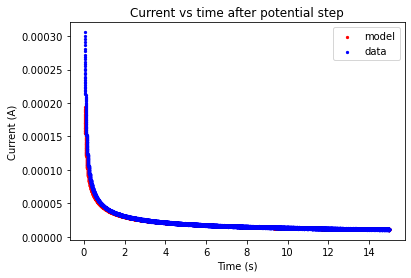

In [52]:
# recalculate time array during the potential step (start of potential step is t=0)
total_step_time = np.arange(0, samp_num_step, 1)/samp_rate

# Slice current data during the potential step. skip the first n points 
n_skip = 50
step_current = Rm_current_data[samp_num_init+n_skip: samp_num_init + samp_num_step]
total_step_time = total_step_time[n_skip:]

# guess diffusion coeff and model data using equation derived in prelab
D = 2e-6
guess_data = fit_func(total_step_time, D)

# plot data
plt.title('Current vs time after potential step')
plt.scatter(total_step_time, guess_data, color = 'red', label = 'model', s = 5)
plt.scatter(total_step_time, step_current, color = 'blue', label = 'data', s = 5)
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
#plt.ylim(-1.5e-4, 0)
plt.legend()

# save data
plt.savefig('diffusion fit.png', dpi = 300, bbox_inches='tight')

In [9]:
'''Code block 4'''

# recalculate time array during the potential step (start of potential step is t=0)
total_step_time = np.arange(0, samp_num_step, 1)/samp_rate

# Slice current data during the potential step. skip the first n points 
n_skip = 50
step_current = Rm_current_data[samp_num_init+n_skip: samp_num_init + samp_num_step]
total_step_time = total_step_time[n_skip:]

# fit data with initial guess for diffusion coefficient (p0 is the initial guess)
fit_param = curve_fit(fit_func, total_step_time, step_current, p0=[6e-7], maxfev=10000)
print(f'Fitted diffusion coefficient is {fit_param[0][0]} cm^2/s' )

# plot data
plt.title('Current vs time after potential step')
plt.scatter(total_step_time, fit_func(total_step_time, fit_param[0]), color = 'red', label = 'model', s = 5)
plt.scatter(total_step_time, step_current, color = 'blue', label = 'data', s = 5)
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
#plt.ylim(-1.5e-4, 0)
plt.legend()

# save data
plt.savefig('diffusion fit-1.png', dpi = 300, bbox_inches='tight')

NameError: name 'Rm_current_data' is not defined

In [12]:
fit_func(1, 2e-6)

4.321949052982613e-05